In [44]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

In [45]:
msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
flux_spec = msfire[:, 1] * 1e-11 # erg/cm^2/s/A to W/m^2/um (species units)
unc = msfire[:, 2]
unc_spec = msfire[:, 2] * 1e-11

In [46]:
target = 'WISE J225540.75-311842.0'
target_short = 'WISE J225540'

file_name = '/Users/bseamons/Documents/Research/Flux_cal_JHK_2M2255-3118.txt'

bt_path = '/Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/'
bt_models = glob(os.path.join(bt_path, '*.7.dat.txt'))

atmo_path = '/Users/bseamons/Documents/Research/atmo_models/'
atmo_models = glob(os.path.join(atmo_path, '*.dat'))

spex_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spex_models = glob(os.path.join(spex_path, '*.txt'))

parallax = 0.0704 # arcseconds
r_jup_km = 69911 # km
r_jup_A = r_jup_km * 1e13 # Å
d_ly = 1 / parallax # distance to target, LY
d_km = d_ly * 9.461e12 # distance to target, km
d_A = d_km * 1e13 # distance to target, Å
scale_km = (r_jup_km ** 2) / (d_km ** 2) # scale factor (r ** 2 / d ** 2), km
scale_A = (r_jup_A ** 2) / (d_A ** 2) # scale factor, Å

RJ = 3318
RH = 3660
RK = 3610
R_array = np.array([RJ, RH, RK])
R = np.average(R_array)

print(f'* Target distance in light-years: {d_ly} ly\n* Target distance in kilometers:  {d_km} km\n* Target distance in angstroms:   {d_A} Å\n')
print(f'* Scaling constant (km):          {scale_km}\n* Scaling constant (Å):           {scale_A}\n')
print(f'* Average resolution:             {R}')

* Target distance in light-years: 14.204545454545453 ly
* Target distance in kilometers:  134389204545454.53 km
* Target distance in angstroms:   1.3438920454545454e+27 Å

* Scaling constant (km):          2.7062147816281133e-19
* Scaling constant (Å):           2.7062147816281133e-19

* Average resolution:             3529.3333333333335


In [87]:
species_bt = np.loadtxt('species_bestfit_bt-settl_model.txt')
spec_bt_wave = species_bt[:, 0]
spec_bt_flux = species_bt[:, 1]

species_atmo = np.loadtxt('species_bestfit_atmo_model.txt')
spec_atmo_wave = species_atmo[:, 0]
spec_atmo_flux = species_atmo[:, 1]

species_atmo_ceq = np.loadtxt('species_bestfit_atmo-ceq.txt')
spec_atmo_ceq_wave = species_atmo_ceq[:, 0]
spec_atmo_ceq_flux = species_atmo_ceq[:, 1]

species_ames_cond = np.loadtxt('species_bestfit_ames-cond.txt')
spec_ames_cond_wave = species_ames_cond[:, 0]
spec_ames_cond_flux = species_ames_cond[:, 1] * 1e-10

species_Tlusty = np.loadtxt('species_bestfit_lacy2023-clear-eq.txt')
spec_Tlusty_wave = species_Tlusty[:, 0]
spec_Tlusty_flux = species_Tlusty[:, 1]

In [48]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

In [71]:
############################################################################
## Smooth and interpolate the species/bt-settl data onto the mosfire data ##
############################################################################

interp_bt = np.interp(wave_um, spec_bt_wave, spec_bt_flux)
range_bt = np.vstack([wave_um, interp_bt])
smooth_bt = convolve_v2(range_bt, R, 1).T
smooth_bt_wave = smooth_bt[:, 0]
smooth_bt_flux = smooth_bt[:, 1]
residuals_bt = flux_spec - smooth_bt_flux * C_bt

C_bt = np.zeros(len(smooth_bt))
G_bt = np.zeros(len(smooth_bt))
for i in range(len(smooth_bt)):
    C_bt = (np.nansum((smooth_bt_flux * flux_spec) / unc_spec ** 2)) / (np.nansum(smooth_bt_flux ** 2 / unc_spec ** 2))
    G_bt = np.nansum(((flux_spec - C_bt * smooth_bt_flux) / unc_spec) ** 2)

print(f'BT-Settl C and G:\n* C: {C_bt}\n* G: {G_bt}')

BT-Settl C and G:
* C: 1.0292153952581293
* G: 51937.44798949131


In [72]:
########################################################################
## Smooth and interpolate the species/atmo data onto the mosfire data ##
########################################################################

interp_atmo = np.interp(wave_um, spec_atmo_wave, spec_atmo_flux)
range_atmo = np.vstack([wave_um, interp_atmo])
smooth_atmo = convolve_v2(range_atmo, R, 1).T
smooth_atmo_wave = smooth_atmo[:, 0]
smooth_atmo_flux = smooth_atmo[:, 1]
residuals_atmo = flux_spec - smooth_atmo_flux * C_atmo

C_atmo = np.zeros(len(smooth_atmo))
G_atmo = np.zeros(len(smooth_atmo))
for i in range(len(smooth_atmo)):
    C_atmo = (np.nansum((smooth_atmo_flux * flux_spec) / unc_spec ** 2)) / (np.nansum(smooth_atmo_flux ** 2 / unc_spec ** 2))
    G_atmo = np.nansum(((flux_spec - C_bt * smooth_atmo_flux) / unc_spec) ** 2)

print(f'ATMO C and G:\n* C: {C_atmo}\n* G: {G_atmo}')

ATMO C and G:
* C: 1.0014751765215493
* G: 62196.882924563506


In [73]:
############################################################################
## Smooth and interpolate the species/atmo_ceq data onto the mosfire data ##
############################################################################

interp_atmo_ceq = np.interp(wave_um, spec_atmo_ceq_wave, spec_atmo_ceq_flux)
range_atmo_ceq = np.vstack([wave_um, interp_atmo_ceq])
smooth_atmo_ceq = convolve_v2(range_atmo_ceq, R, 1).T
smooth_atmo_ceq_wave = smooth_atmo_ceq[:, 0]
smooth_atmo_ceq_flux = smooth_atmo_ceq[:, 1]
residuals_atmo_ceq = flux_spec - smooth_atmo_ceq_flux * C_atmo_ceq

C_atmo_ceq = np.zeros(len(smooth_atmo_ceq))
G_atmo_ceq = np.zeros(len(smooth_atmo_ceq))
for i in range(len(smooth_atmo_ceq)):
    C_atmo_ceq = (np.nansum((smooth_atmo_ceq_flux * flux_spec) / unc_spec ** 2)) / (np.nansum(smooth_atmo_ceq_flux ** 2 / unc_spec ** 2))
    G_atmo_ceq = np.nansum(((flux_spec - C_bt * smooth_atmo_ceq_flux) / unc_spec) ** 2)

print(f'ATMO CEQ C and G:\n* C: {C_atmo_ceq}\n* G: {G_atmo_ceq}')

ATMO CEQ C and G:
* C: 1.0011283411308909
* G: 64878.996763403884


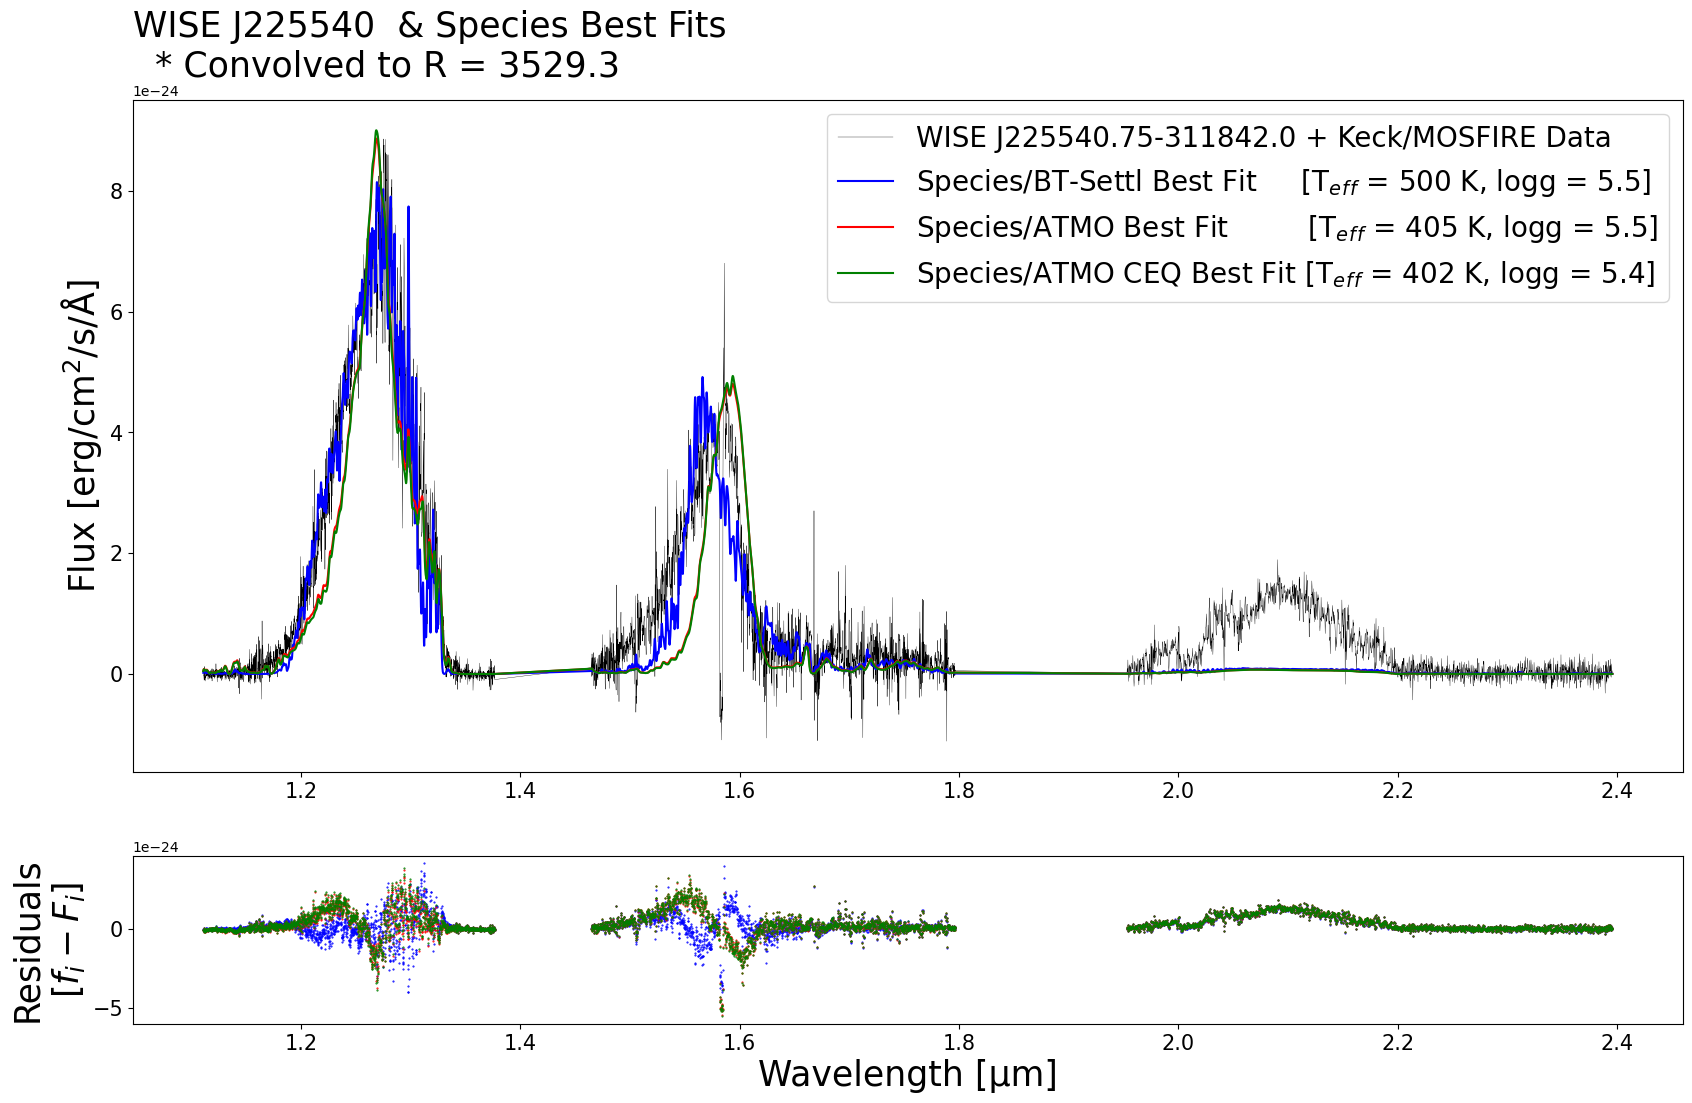

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux_spec, color = 'black', linewidth = 0.25, label = f'{target} + Keck/MOSFIRE Data')
ax1.plot(smooth_bt_wave, smooth_bt_flux * C_bt, color = 'blue', label = r'Species/BT-Settl Best Fit     [T$_e$$_f$$_f$ = 500 K, logg = 5.5]')
ax1.plot(smooth_atmo_wave, smooth_atmo_flux * C_atmo, color = 'red', label = r'Species/ATMO Best Fit         [T$_e$$_f$$_f$ = 405 K, logg = 5.5]')
ax1.plot(smooth_atmo_ceq_wave, smooth_atmo_ceq_flux * C_atmo_ceq, color = 'green', label = r'Species/ATMO CEQ Best Fit [T$_e$$_f$$_f$ = 402 K, logg = 5.4]')

ax1.set_title(f'{target_short}  & Species Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
ax1.set_ylabel(f'Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)

ax2.scatter(wave_um, residuals_bt, color = 'blue', marker = '.', s = 1)
ax2.scatter(wave_um, residuals_atmo, color = 'red', marker = '.', s = 1)
ax2.scatter(wave_um, residuals_atmo_ceq, color = 'green', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('WISE J225540 and Species Best Fits (bt-settl, atmo, atmo-ceq)')

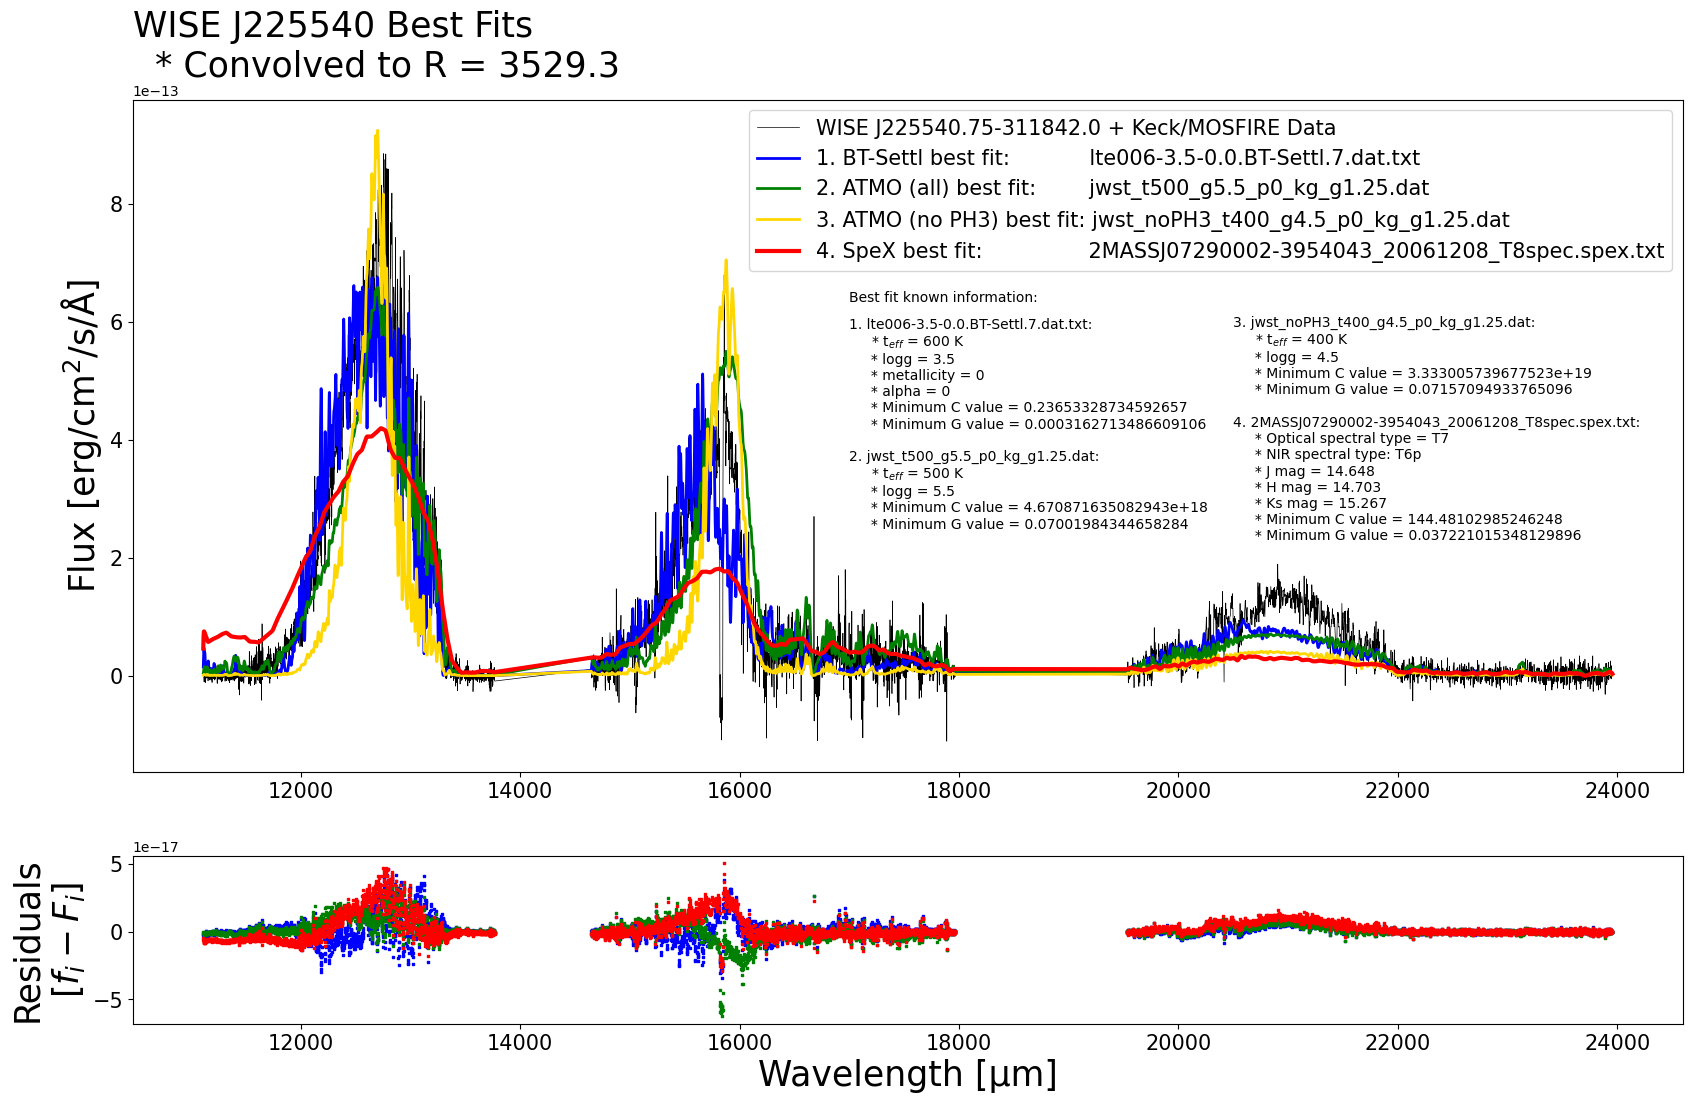

In [5]:
bdat = np.loadtxt('BT-Settl_data[27].txt')
b_CG = np.loadtxt('BT-Settl_minC&G[27].txt')
bwave = bdat[0, :]
bflux = bdat[1, :] * 1e4
bresiduals = bdat[2, :]
bC = b_CG[0]
bG = b_CG[1]

adat = np.loadtxt('ATMO_data[6].txt')
a_CG = np.loadtxt('ATMO_minC&G[6].txt')
awave = adat[0, :]
aflux = adat[1, :]
aresiduals = adat[2, :]
aC = a_CG[0]
aG = a_CG[1]

adat_noPH3 = np.loadtxt('ATMO no PH3_data[12].txt')
adat_noPH3_CG = np.loadtxt('ATMO no PH3_minC&G[12].txt')
anoPH3_wave = adat_noPH3[0, :]
anoPH3_flux = adat_noPH3[1, :]
anoPH3C = adat_noPH3_CG[0]
anoPH3G = adat_noPH3_CG[1]

sdat = np.loadtxt('SpeX_data[20].txt')
s_CG = np.loadtxt('SpeX_minC&G[20].txt')
swave = sdat[0, :]
sflux = sdat[1, :]
sresiduals = sdat[2, :]
sC = s_CG[0]
sG = s_CG[1]

string1 = f'{bt_models[27][69:]}:\n     * t$_e$$_f$$_f$ = 600 K\n     * logg = 3.5\n     * metallicity = 0\n     * alpha = 0\n     * Minimum C value = {bC}\n     * Minimum G value = {bG}\n\n'
string2 = f'{atmo_models[6][52:]}:\n     * t$_e$$_f$$_f$ = 500 K\n     * logg = 5.5\n     * Minimum C value = {aC}\n     * Minimum G value = {aG}'
string3 = f'{atmo_models[25][52:]}:\n     * t$_e$$_f$$_f$ = 400 K\n     * logg = 4.5\n     * Minimum C value = {anoPH3C}\n     * Minimum G value = {anoPH3G}\n\n'
string4 = f'{spex_models[20][68:]}:\n     * Optical spectral type = T7\n     * NIR spectral type: T6p\n     * J mag = 14.648\n     * H mag = 14.703\n     * Ks mag = 15.267\n     * Minimum C value = {sC}\n     * Minimum G value = {sG}'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave, flux, color = 'black', linewidth = 0.5, label = f'{target} + Keck/MOSFIRE Data')
ax1.plot(bwave, bflux, color = 'blue', linewidth = 2, label = f'1. BT-Settl best fit:            {bt_models[27][69:]}')
ax1.plot(awave, aflux * 1e4, color = 'green', linewidth = 2, label = f'2. ATMO (all) best fit:        {atmo_models[6][52:]}')
ax1.plot(anoPH3_wave, anoPH3_flux * 1e4, color = 'gold', linewidth = 2, label = f'3. ATMO (no PH3) best fit: {atmo_models[25][52:]}')
ax1.plot(swave, sflux * 1e4, color = 'red', linewidth = 3, label = f'4. SpeX best fit:                {spex_models[20][68:]}')
ax1.set_title(f'{target_short} Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
ax1.set_ylabel(f'Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
ax1.annotate(f'Best fit known information:\n\n', (17000, 5.8e-13), fontsize = 10)
ax1.annotate(f'1. {string1}2. {string2}', (17000, 2.5e-13), fontsize = 10)
ax1.annotate(f'3. {string3}4. {string4}', (20500, 2.3e-13), fontsize = 10)

ax2.scatter(wave, bresiduals, color = 'blue', marker = ',', s = 1)
ax2.scatter(wave, aresiduals, color = 'green', marker = ',', s = 1)
ax2.scatter(wave, sresiduals, color = 'red', marker = ',', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)